In [308]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from minisom import MiniSom

SEED = 42
random.seed(a=SEED)
np.random.seed(seed=SEED)

base_df: pd.DataFrame = pd.read_csv(filepath_or_buffer="data_1.csv", index_col=0)

In [309]:
# only numeric columns allowed!
columns = base_df.columns
columns

Index(['score', 'salary', 'happiness', 'Age'], dtype='object')

In [310]:
som_df: pd.DataFrame = base_df.copy()
som_df.dropna(axis=0, inplace=True)

data = (som_df - np.mean(a=som_df, axis=0)) / np.std(a=som_df, axis=0)
data = data.values
data

array([[ 1.0429975 ,  0.57588839,  0.30655913,  0.68449643],
       [-0.12305385,  0.29779663,  0.96420041,  1.19651135],
       [ 0.19496016, -0.35960307, -0.42030754,  0.96894916],
       ...,
       [-0.01704918,  0.07794223, -0.38569484, -0.56709558],
       [-0.29972829,  4.22368921,  0.99881311,  1.65163572],
       [ 0.01828571,  0.12304636,  0.27194643, -0.90843886]])

In [311]:
x_neurons = 16
y_neurons = 16
som = MiniSom(
    x=x_neurons,
    y=y_neurons,
    input_len=columns.shape[0], #num features
    sigma=1.5,
    learning_rate=0.5,
    random_seed=SEED,
    neighborhood_function="gaussian",
    topology="hexagonal",
)

In [312]:
som.train(data=data, num_iteration=30000, verbose=True)

 [  1783 / 30000 ]   6% - 0:00:03 left 

 [ 30000 / 30000 ] 100% - 0:00:00 left 
 quantization error: 0.3085877772913421


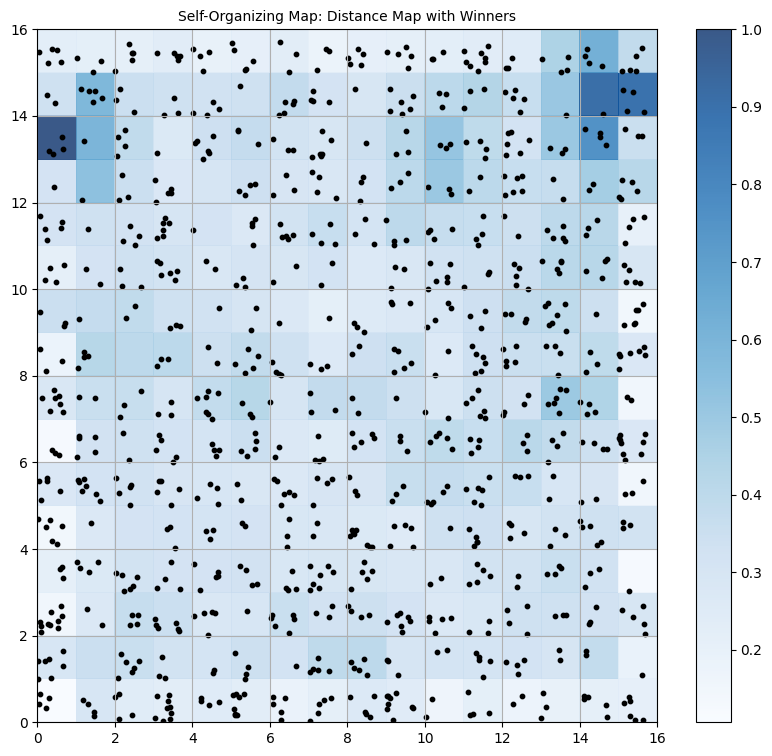

In [313]:
# colors = ['C0', 'C1', 'C2']
w_x, w_y = zip(*[som.winner(x=d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

w_x_noise = w_x + (np.random.rand(len(w_x)) * 0.7)
w_y_noise = w_y + (np.random.rand(len(w_y)) * 0.7)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap="Blues", alpha=0.8)
plt.colorbar()

plt.scatter(
    x=w_x_noise,
    y=w_y_noise,
    s=10,
    c="black",
)

plt.grid()
plt.title(label='Self-Organizing Map: Distance Map with Winners', fontsize=10)
plt.savefig("figures/som_distance_map_with_winners.png")
plt.show()

Error treshold: 0.8429997308707468


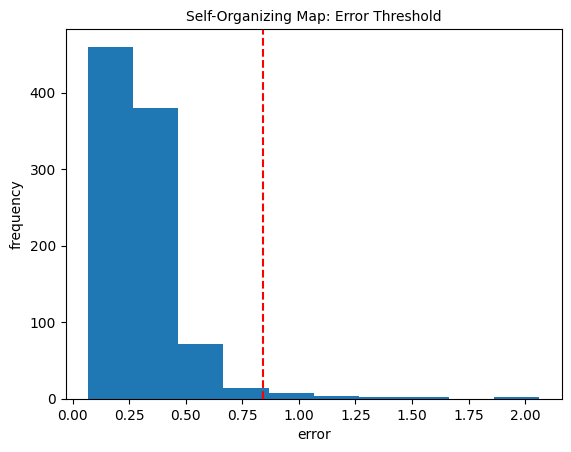

In [314]:
outliers_percentage = 0.07

quantization_errors = np.linalg.norm(som.quantization(data) - data, axis=1)
error_treshold = np.percentile(quantization_errors, 
                               100*(1-outliers_percentage)+5)

print('Error treshold:', error_treshold)

is_outlier = quantization_errors > error_treshold

plt.hist(x=quantization_errors)
plt.axvline(x=error_treshold, color='r', linestyle='--')
plt.xlabel(xlabel='error')
plt.ylabel(ylabel='frequency')
plt.title(label='Self-Organizing Map: Error Threshold', fontsize=10)
plt.savefig("figures/som_frequency_error.png")
plt.show()

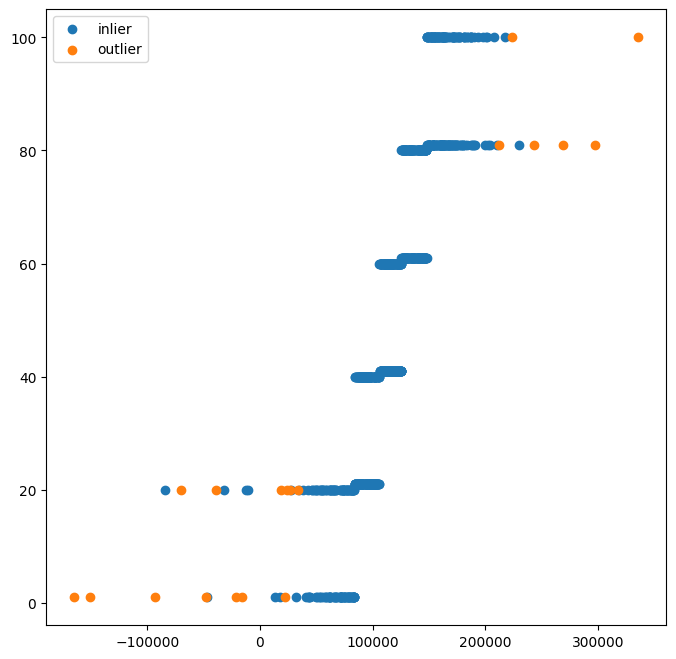

In [315]:
# Inspect two features in som and check outliers
plt.figure(figsize=(8, 8))
plt.scatter(
    x=som_df.values[~is_outlier, 1],
    y=som_df.values[~is_outlier, 2],
    label="inlier",
)
plt.scatter(
    x=som_df.values[is_outlier, 1],
    y=som_df.values[is_outlier, 2],
    label="outlier",
)
plt.legend()
#plt.title(label="Self-Organizing Map: Outlier", fontsize=10)
#plt.savefig("figures/som_outlier_detection.png")
plt.show()

In [316]:
# add is_outlier to the dataframe som_df
som_df["is_outlier"] = is_outlier
som_df.head()

,score,salary,happiness,Age,is_outlier
0,80,141890.771857,61.0,62,False
1,47,130053.860492,80.0,71,False
2,56,102071.794659,40.0,67,False
3,37,90975.540309,21.0,27,False
4,70,109558.368794,41.0,77,False


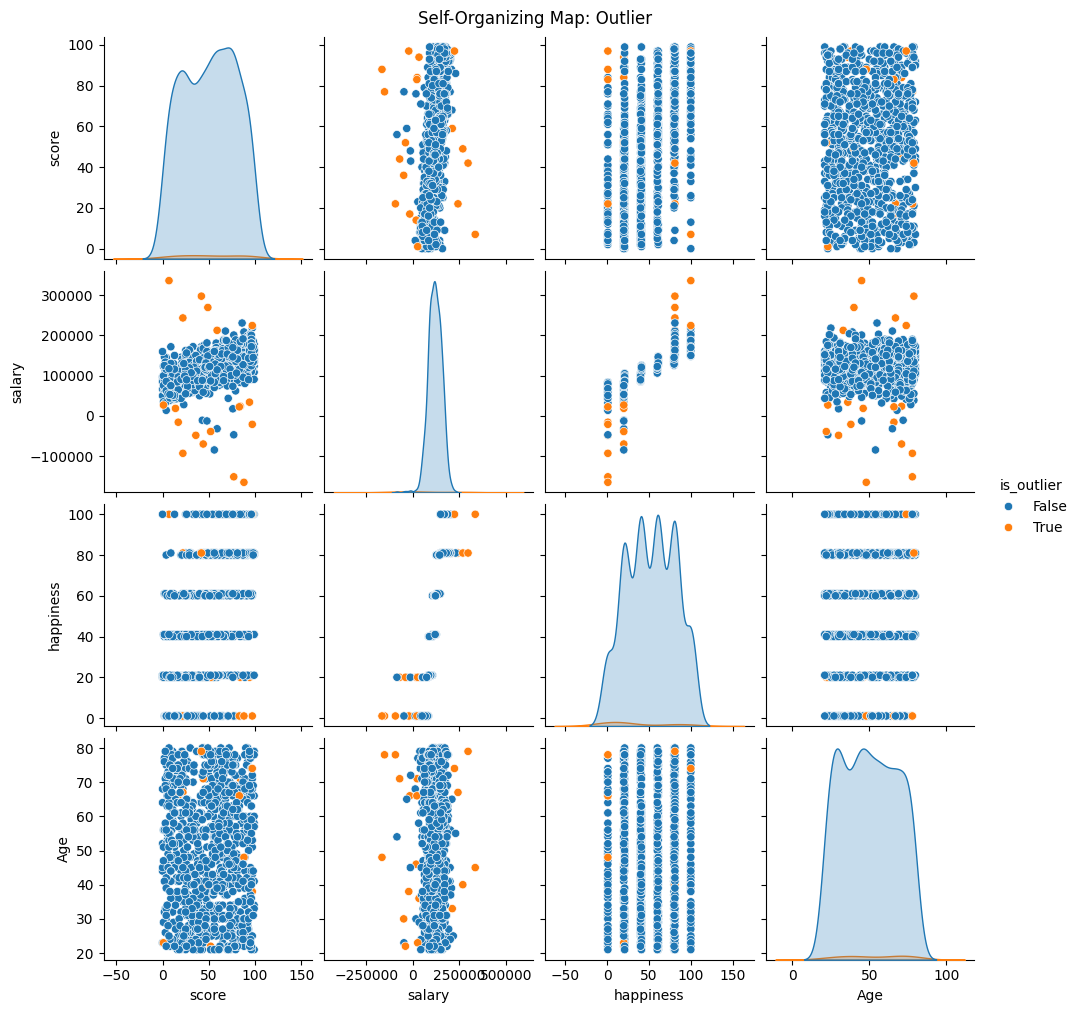

In [317]:
# pairplot the som_df with seaborn and use the is_outlier array to color the points in the pairplot
g = sns.pairplot(
    data=som_df,
    hue="is_outlier",
)
g.fig.suptitle(t="Self-Organizing Map: Outlier", y=1.01) # y= some height>1
plt.savefig("figures/som_outlier_detection.png")
plt.show()